# import libraries

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [14]:
!pip install tensorflow

  Using cached tensorflow-2.20.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.5 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 733.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


# data preprocessing

In [16]:
# data_path = "Teeth_Dataset"
data_path = "/content/drive/MyDrive/cellula/Teeth_Dataset"
dirs = os.listdir(data_path)  # getting the names of the directorie, like training and val
labels = os.listdir(os.path.join(data_path, 'Training')) # getting the names of the classes
print(dirs)
print(labels)

label_item = {label:0 for label in labels}

for dir in dirs:
    for label in labels:
        num = len(os.listdir(os.path.join(data_path, dir, label))) # count of pictures for each class
        label_item[label] += num
print(label_item)

['Validation', 'Training', 'Testing']
['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
{'CaS': 800, 'CoS': 748, 'Gum': 600, 'MC': 900, 'OC': 540, 'OLP': 900, 'OT': 655}


Text(0.5, 0, 'classes')

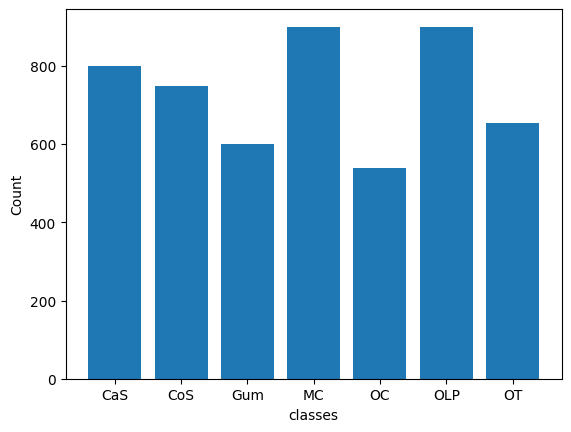

In [17]:
plt.bar(label_item.keys(), label_item.values())
plt.ylabel('Count')
plt.xlabel('classes')

In [18]:
train_datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range = 40,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True,
                             fill_mode = 'nearest',
                             )

test_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
train_path = os.path.join(data_path, 'Training')
test_path = os.path.join(data_path, 'Testing')
val_path = os.path.join(data_path, 'Validation')
img_w = 128
img_h = 128
batch_size = 64

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(img_w, img_h),
                                                    batch_size=batch_size,
                                                    class_mode='categorical'
                                                    )

val_generator = test_datagen.flow_from_directory(val_path,
                                                 target_size=(img_w, img_h),
                                                 batch_size=batch_size,
                                                 class_mode='categorical'
                                                )
test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(img_w, img_h),
                                                  batch_size=batch_size,
                                                  class_mode='categorical'
                                                 )

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [20]:
no_aug_generator = test_datagen.flow_from_directory(train_path,
                                                target_size=(img_w, img_h),
                                                batch_size=batch_size,
                                                class_mode='categorical'
                                               )

Found 3087 images belonging to 7 classes.


In [21]:
encoder = no_aug_generator.class_indices
decoder = {v:k for k, v in encoder.items()}
decoder

{0: 'CaS', 1: 'CoS', 2: 'Gum', 3: 'MC', 4: 'OC', 5: 'OLP', 6: 'OT'}

## images before augmentation

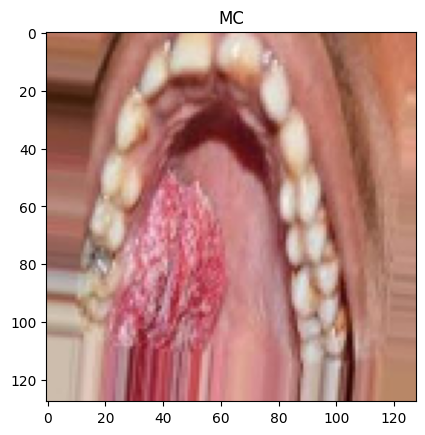

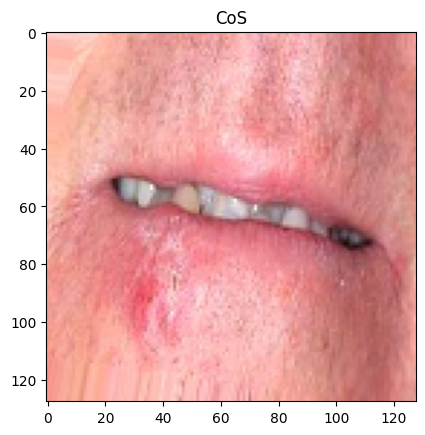

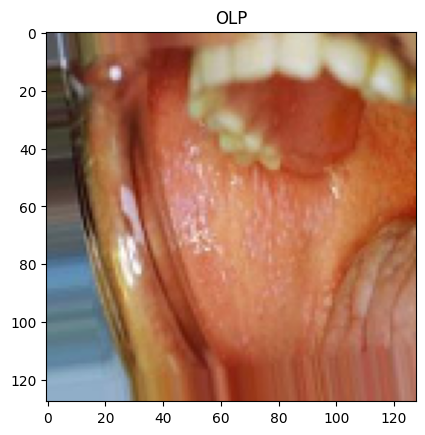

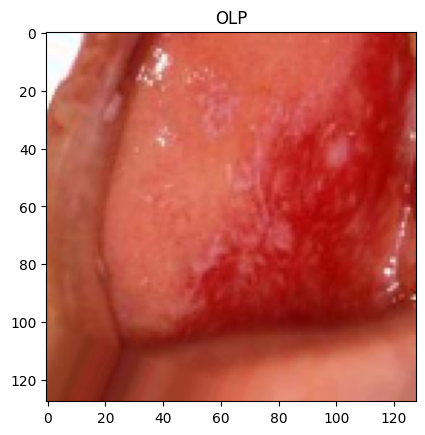

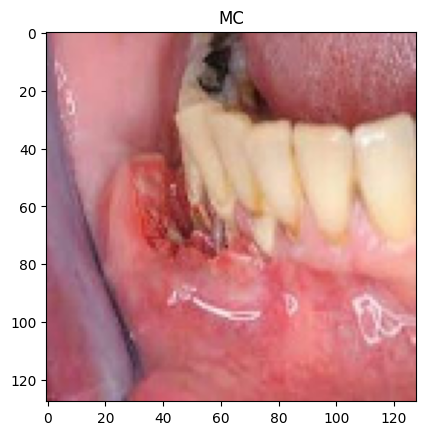

In [22]:
images, labels = next(no_aug_generator)

for image, label in zip(images[:5], labels[:5]):
    plt.imshow(image)
    plt.title(decoder[np.argmax(label)])
    plt.show()

## images after augmentation

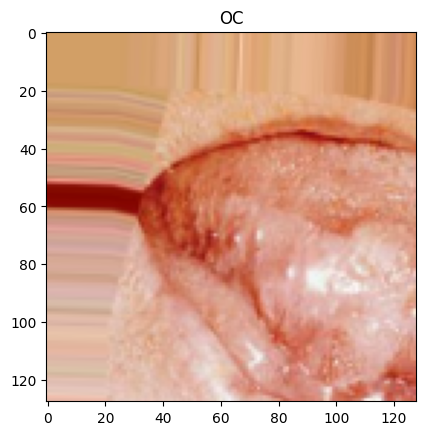

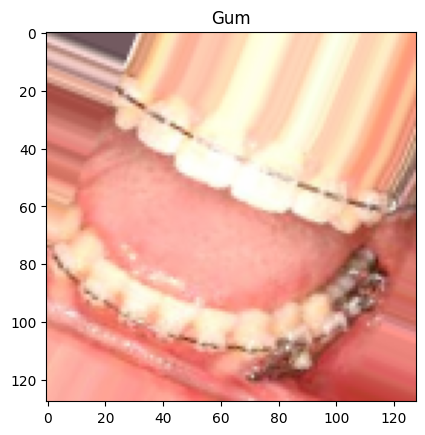

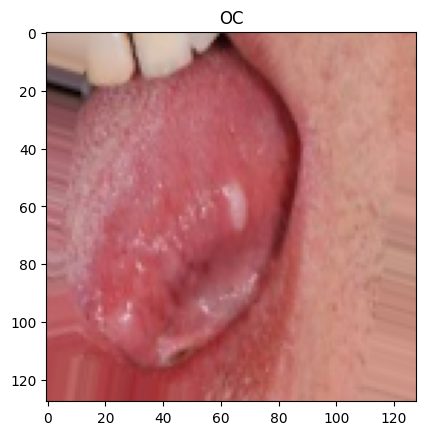

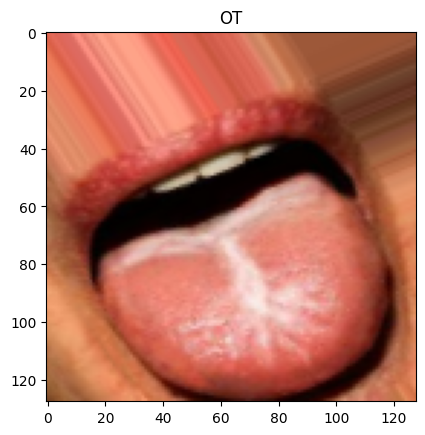

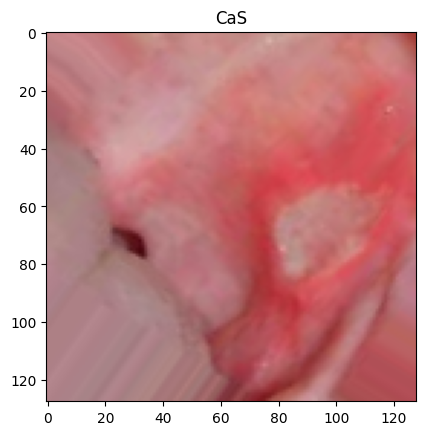

In [23]:
images, labels = next(train_generator)

for image, label in zip(images[:5], labels[:5]):
    plt.imshow(image)
    plt.title(decoder[np.argmax(label)])
    plt.show()

# Model Architecture and Training

In [24]:
n_epochs = 20
lr = 0.001

In [25]:
model = keras.models.Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape = (img_w, img_h, 3)),
    MaxPooling2D(2,2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2,2),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2,2),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2,2),

    Flatten(),

    Dense(128, activation = "relu"),
    Dropout(0.4),

    Dense(64, activation = "relu"),
    Dropout(0.4),

    Dense(7, activation = "softmax")
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate = lr),
              loss = "binary_crossentropy",
              metrics = ['accuracy']
             )
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,754,119 (21.95 MB)

 Trainable params: 5,754,119 (21.95 MB)

 Non-trainable params: 0 (0.00 B)

None


In [27]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

check_point = ModelCheckpoint(filepath = "model_checkpoint.keras",
                              monitor='val_accuracy',
                              mode = "max",
                              save_best_only = True,
                              verbose = 1)

early_stop = EarlyStopping(monitor = 'val_accuracy',
                           patience = 4,
                           restore_best_weights=True
                          )


In [29]:
history = model.fit(train_generator,
          epochs = n_epochs,
          batch_size = batch_size,
          validation_data = val_generator,
          validation_batch_size = batch_size,
          callbacks=[check_point, early_stop]
         )

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.1516 - loss: 0.4543 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from inf to 0.17510, saving model to model_checkpoint.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 1017s 21s/step - accuracy: 0.1515 - loss: 0.4541 - val_accuracy: 0.1751 - val_loss: 0.4101
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.1567 - loss: 0.4356
Epoch 2: val_accuracy did not improve from 0.17510
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 694ms/step - accuracy: 0.1569 - loss: 0.4355 - val_accuracy: 0.2374 - val_loss: 0.4022
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.1817 - loss: 0.4250
Epoch 3: val_accuracy did not improve from 0.17510
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 721ms/step - accuracy: 0.1818 - loss: 0.4250 - val_accuracy: 0.2685 - val_loss: 0.3971
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.1944 - loss: 0.4193
Epoch 4: val_accuracy did not improve from 0.17510
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 690ms/step - accuracy: 0.1944 - loss: 0.4192 - val_accuracy: 0.2850 - val_loss: 0.3947
Epoch 5/20
49/49 ━━━━━━━━

In [30]:
history2 = model.fit(train_generator,
           epochs = n_epochs,
           batch_size = batch_size,
           validation_data = val_generator,
           validation_batch_size = batch_size,
           callbacks=[check_point, early_stop]
         )

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.4936 - loss: 0.3072
Epoch 1: val_accuracy did not improve from 0.17510
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 697ms/step - accuracy: 0.4936 - loss: 0.3072 - val_accuracy: 0.6119 - val_loss: 0.2564
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.4778 - loss: 0.3061
Epoch 2: val_accuracy did not improve from 0.17510
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 697ms/step - accuracy: 0.4779 - loss: 0.3061 - val_accuracy: 0.6060 - val_loss: 0.2602
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.4744 - loss: 0.3133
Epoch 3: val_accuracy did not improve from 0.17510
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 688ms/step - accuracy: 0.4743 - loss: 0.3133 - val_accuracy: 0.6119 - val_loss: 0.2635
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.5049 - loss: 0.2982
Epoch 4: val_accuracy did not improve from 0.17510
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 692ms/step - accuracy: 0.5050 - loss: 0.2982 - val_accuracy: 0.6605

In [31]:
history3 = model.fit(train_generator,
           epochs = n_epochs,
           batch_size = batch_size,
           validation_data = val_generator,
           validation_batch_size = batch_size,
           callbacks=[check_point, early_stop]
         )

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.7194 - loss: 0.1926
Epoch 1: val_accuracy did not improve from 0.17510
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 698ms/step - accuracy: 0.7193 - loss: 0.1928 - val_accuracy: 0.7101 - val_loss: 0.1920
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.6475 - loss: 0.2401
Epoch 2: val_accuracy did not improve from 0.17510
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 695ms/step - accuracy: 0.6479 - loss: 0.2399 - val_accuracy: 0.8239 - val_loss: 0.1280
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.7158 - loss: 0.1924
Epoch 3: val_accuracy did not improve from 0.17510
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 700ms/step - accuracy: 0.7159 - loss: 0.1924 - val_accuracy: 0.8405 - val_loss: 0.1158
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.7436 - loss: 0.1826
Epoch 4: val_accuracy did not improve from 0.17510
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 698ms/step - accuracy: 0.7435 - loss: 0.1826 - val_accuracy: 0.8745

In [32]:
history4 = model.fit(train_generator,
           epochs = n_epochs,
           batch_size = batch_size,
           validation_data = val_generator,
           validation_batch_size = batch_size,
           callbacks=[check_point, early_stop]
         )

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.8543 - loss: 0.1172
Epoch 1: val_accuracy did not improve from 0.17510
49/49 ━━━━━━━━━━━━━━━━━━━━ 36s 722ms/step - accuracy: 0.8543 - loss: 0.1171 - val_accuracy: 0.9553 - val_loss: 0.0401
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.8490 - loss: 0.1139
Epoch 2: val_accuracy did not improve from 0.17510
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 728ms/step - accuracy: 0.8491 - loss: 0.1139 - val_accuracy: 0.9407 - val_loss: 0.0541
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.8503 - loss: 0.1199
Epoch 3: val_accuracy did not improve from 0.17510
49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 747ms/step - accuracy: 0.8502 - loss: 0.1199 - val_accuracy: 0.9494 - val_loss: 0.0419
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.8570 - loss: 0.1069
Epoch 4: val_accuracy did not improve from 0.17510
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 713ms/step - accuracy: 0.8569 - loss: 0.1069 - val_accuracy: 0.9514

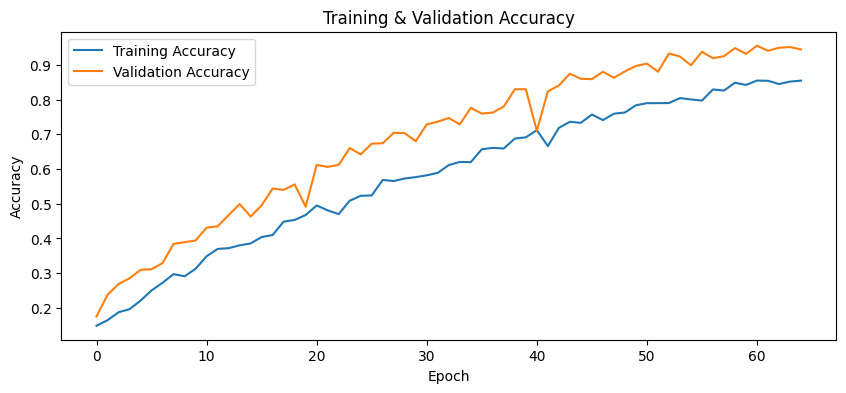

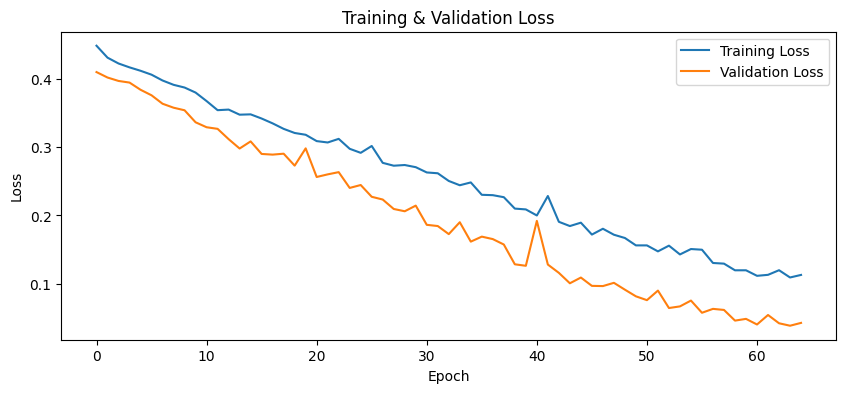

In [33]:
histories = [history, history2, history3, history4]

acc = []
val_acc = []
loss = []
val_loss = []

for h in histories:
    acc.extend(h.history['accuracy'])
    val_acc.extend(h.history['val_accuracy'])
    loss.extend(h.history['loss'])
    val_loss.extend(h.history['val_loss'])

# plot accuracy
plt.figure(figsize=(10, 4))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training & Validation Accuracy")

plt.show()

# plot loss
plt.figure(figsize=(10, 4))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training & Validation Loss")

plt.show()

In [34]:
model.evaluate(test_generator)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 377s 22s/step - accuracy: 0.9550 - loss: 0.0353


[0.036090027540922165, 0.9523346424102783]